In [3]:
# Import libraries
import logging
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import shap
import joblib
import lime
from lime import lime_tabular
from lime import submodular_pick
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV,GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.metrics import confusion_matrix, f1_score, make_scorer, classification_report, cohen_kappa_score, precision_score, recall_score, balanced_accuracy_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import optuna
from optuna.visualization.matplotlib import plot_optimization_history


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Supporting Function

In [2]:
 # Function to assess Model performance
def conf_matrix_classif_report(model, y_test, y_pred_val):
  """
  model : str variable with model name to be used for titles.
  y_test : Variable with True label list
  y_pred_val : Variable with Model predicted values.
  """

  # Target classes
  class_label = ['3','4','5']

  # Model primary metric: f1 macro score
  model_f1_macro_score= f1_score(y_test, y_pred_val, average='macro')
  print('')
  print(f"{model} f1 macro score: {model_f1_macro_score}")

  # Model support metric: precision macro score
  model_precision_macro_score = precision_score(y_test, y_pred_val, average='macro')
  print('')
  print(f"{model} precision macro score: {model_precision_macro_score}")

  # Model support metric: recall macro score
  model_recall_macro_score = recall_score(y_test, y_pred_val, average='macro')
  print('')
  print(f"{model} recall macro score: {model_recall_macro_score}")

   # Model support metric: balanced accuracy score
  model_balanced_accuracy_score= balanced_accuracy_score(y_test, y_pred_val)
  print('')
  print(f"{model} balanced accuracy score: {model_balanced_accuracy_score}")

   # Model support metric: accuracy score
  model_accuracy_score= accuracy_score(y_test, y_pred_val)
  print('')
  print(f"{model} accuracy score: {model_accuracy_score}")

  # Model support metric: cohen kappa score
  model_cohen_kappa_score= cohen_kappa_score(y_test, y_pred_val)
  print('')
  print(f"{model} cohen kappa score: {model_cohen_kappa_score}")

  # Classification report
  classif_report = classification_report(y_test, y_pred_val)
  print('')
  print(f"Classification Report:\n\n{classif_report}")
  print('')
  
  # Confusion matrix
  conf_matrix = confusion_matrix(y_test, y_pred_val)
  sns.set(font_scale=1.2) 
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  tick_pos = np.arange(len(class_label)) + 0.5
  plt.xticks(tick_pos, class_label)
  plt.yticks(tick_pos, class_label)
  plt.title(f"Confusion Matrix: {model}")
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.show()

In [4]:
# ROC AUC Score function
def roc_curves(model,y_train, y_test, y_pred):
    # Reshape target label
    y_train_reshaped_ohe = y_train.reshape(-1, 1)
    y_test_reshaped_ohe = y_test.reshape(-1, 1)
    y_pred_reshaped_ohe = y_pred.reshape(-1, 1)

    # OneHotEncode reshaped target label 
    ohe  = OneHotEncoder(sparse=False, handle_unknown='ignore')
    y_train_ohe = ohe.fit_transform(y_train_reshaped_ohe)
    y_test_ohe = ohe.transform(y_test_reshaped_ohe)
    y_pred_ohe = ohe.transform(y_pred_reshaped_ohe)

    # Compute ROC cuver and calculate AUC score 
    for i in range(y_train_ohe.shape[1]):
      fpr, tpr, _ = roc_curve(y_test_ohe[:,i], y_pred_ohe[:,i]) # Compute ROC curve for the current class
      auc_score = roc_auc_score(y_test_ohe[:,i], y_pred_ohe[:,i]) # Calculate AUC score for the ROC curve
      # Plot ROC curve and class label together with AUC
      plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='-',color='black')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{model} - ROC Curves")
    plt.legend(loc='lower right')
    plt.show()

In [5]:
# Load file paths
full_dataset = "add_path_file"

In [6]:
# Load datasets
bike_full_df = pd.read_csv(full_dataset, header = 0, sep = ';')
print(bike_full_df.shape)

(2035394, 43)


Step selecting Age groups of interest: 

In [7]:
# Removing Unknown ageRange: 0  from dataset
bike_full_df = bike_full_df[bike_full_df['ageRange'].isin([3,4,5])]

print(bike_full_df.shape)
print(bike_full_df.dtypes)

(1991440, 43)
_id                           object
user_day_code                 object
idplug_base                    int64
user_type                      int64
idunplug_base                  int64
travel_time                    int64
idunplug_station               int64
ageRange                       int64
idplug_station                 int64
unplug_hourTime               object
zip_code                      object
temp_unplug_hourTime          object
year                           int64
month                          int64
day                            int64
hour                           int64
travel_time_min              float64
travel_revenue               float64
id_weather                     int64
80                           float64
81                           float64
82                           float64
83                           float64
86                           float64
87                           float64
88                           float64
89                      

In [8]:
bike_full_df['ageRange'].unique()

array([5, 3, 4], dtype=int64)

In [9]:
# Remove outliers
bike_full_df = bike_full_df[bike_full_df['travel_time_min']<=30]
bike_full_df.shape

(1905493, 43)

## Feature Selection

In [10]:
bike_full_df.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['_id', 'user_day_code', 'idplug_base', 'user_type', 'idunplug_base',
       'travel_time', 'idunplug_station', 'ageRange', 'idplug_station',
       'unplug_hourTime', 'zip_code', 'temp_unplug_hourTime', 'year', 'month',
       'day', 'hour', 'travel_time_min', 'travel_revenue', 'id_weather', '80',
       '81', '82', '83', '86', '87', '88', '89', 'date', 'week_day',
       'WorkingDay_Holiday_Sunday', 'holiday_type', 'holiday_desc',
       'day_of_week', 'unplug_station_tot_bases', 'idunplug_latitude',
       'idunplug_longitude', 'plug_station_tot_bases', 'idplug_latitude',
       'idplug_longitude', 'mh_distance_meters', 'time_group',
       'unique_user_day_code', 'tot_trips_day'],
      dtype='object')>

In [11]:
# Feature selection
bike_full_df.columns.to_list
selected_columns = [
    #'idplug_base', 
    #'idunplug_base',
    'travel_time', 
    #'idunplug_station', # Replaced with idunplug_latitude / longitude
    'idunplug_latitude',
    'idunplug_longitude',
    'unplug_station_tot_bases',
    'ageRange', 
    #'idplug_station', # Replaced with iduplug_latitude / longitude
    'idplug_latitude',
    'idplug_longitude',
    'plug_station_tot_bases',
    #'unplug_hourTime', 
    #'zip_code',
    #'year', 
    'month',
    'day', 
    'hour',
    'time_group', 
    'travel_revenue',
    'tot_trips_day',
    'mh_distance_meters', 
    #'80', # Contains NaN Values
    '81', 
    '82', 
    '83', 
    '86', 
    '87', 
    '88', 
    '89',
    'day_of_week',
    #'WorkingDay_Holiday_Sunday', 
    'holiday_type' 
    #'holiday_desc',
       ]


filter_bike_df = bike_full_df[selected_columns]
print(filter_bike_df.dtypes)
display(filter_bike_df.head())

print(f"Present NA values: {filter_bike_df.isna().sum()}")

travel_time                   int64
idunplug_latitude           float64
idunplug_longitude          float64
unplug_station_tot_bases      int64
ageRange                      int64
idplug_latitude             float64
idplug_longitude            float64
plug_station_tot_bases        int64
month                         int64
day                           int64
hour                          int64
time_group                    int64
travel_revenue              float64
tot_trips_day                 int64
mh_distance_meters          float64
81                          float64
82                          float64
83                          float64
86                          float64
87                          float64
88                          float64
89                          float64
day_of_week                   int64
holiday_type                 object
dtype: object


,travel_time,idunplug_latitude,idunplug_longitude,unplug_station_tot_bases,ageRange,idplug_latitude,idplug_longitude,plug_station_tot_bases,month,day,hour,time_group,travel_revenue,tot_trips_day,mh_distance_meters,81,82,83,86,87,88,89,day_of_week,holiday_type
0,415,40.403408,-3.710811,24,5,40.415010,-3.706103,18,1,1,0,0,0.5,1,1760.389172,0.69,22.0,4.4,67.0,957.0,101.0,0.0,1,national_holiday
1,417,40.424846,-3.673863,24,3,40.444226,-3.678717,18,1,1,0,0,0.5,1,2641.794256,0.69,22.0,4.4,67.0,957.0,101.0,0.0,1,national_holiday
2,448,40.404785,-3.702827,24,4,40.413885,-3.704941,24,1,1,0,0,0.5,1,1221.373443,0.69,22.0,4.4,67.0,957.0,101.0,0.0,1,national_holiday
3,468,40.422658,-3.687055,24,5,40.429887,-3.671282,24,1,1,0,0,0.5,1,2405.058377,0.69,22.0,4.4,67.0,957.0,101.0,0.0,1,national_holiday
4,149,40.417924,-3.670896,24,4,40.421398,-3.675204,24,1,1,0,0,0.5,1,821.854857,0.69,22.0,4.4,67.0,957.0,101.0,0.0,1,national_holiday


Present NA values: travel_time                 0
idunplug_latitude           0
idunplug_longitude          0
unplug_station_tot_bases    0
ageRange                    0
idplug_latitude             0
idplug_longitude            0
plug_station_tot_bases      0
month                       0
day                         0
hour                        0
time_group                  0
travel_revenue              0
tot_trips_day               0
mh_distance_meters          0
81                          0
82                          0
83                          0
86                          0
87                          0
88                          0
89                          0
day_of_week                 0
holiday_type                0
dtype: int64


## Train, test split

In [12]:
# Set up random state for reproducible results
rand_state = 123

# Set up number of folds for cross validation:
numb_split = 5

In [13]:
# Train, test split stratify based on ageRange
train, test = train_test_split(filter_bike_df, stratify=filter_bike_df["ageRange"],test_size=0.20, random_state=rand_state)

In [14]:
# Splitting target vs independent variables
X_train = train.drop("ageRange", axis=1)
y_train = train["ageRange"].values

X_test = test.drop("ageRange", axis=1)
y_test = test["ageRange"].values

In [15]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train length: {len(y_train)}")
print("")
print(f"X_test shape: {X_test.shape}")
print(f"y_test length: {len(y_test)}")

X_train shape: (1524394, 23)
y_train length: 1524394

X_test shape: (381099, 23)
y_test length: 381099


### Common Preprocessing:

In [16]:
# Common Preprocessing steps:
featurizer = ColumnTransformer(
    transformers=[
        ('one_hot_en',OneHotEncoder(sparse=False, handle_unknown='ignore'),['holiday_type'
                                                                            ]),
        ('normalization',MinMaxScaler(),['travel_time',
                                         'idunplug_latitude',
                                         'idunplug_longitude',
                                         'unplug_station_tot_bases',
                                         'idplug_latitude',
                                         'idplug_longitude',
                                         'plug_station_tot_bases',
                                         'tot_trips_day',
                                         'travel_revenue',
                                         'mh_distance_meters',
                                         '81',
                                         '82',
                                         '83',
                                         '86',
                                         '87',
                                         '88',
                                         '89'
                                            ]
                                            )                                        
                ],
                                                remainder='passthrough')

In [17]:
# Test transformation
X_train_trans = featurizer.fit_transform(X_train)
X_test_trans = featurizer.transform(X_test)
display(X_train_trans[[0],])
display(y_train.shape)

array([[0.        , 0.        , 0.        , 0.        , 1.        ,
        0.54196776, 0.5850373 , 0.43096397, 0.66666667, 0.40579311,
        0.42176765, 0.66666667, 0.05263158, 0.25      , 0.15410796,
        0.15849057, 0.        , 0.86879433, 0.21052632, 0.64864865,
        0.68548387, 0.        , 9.        , 3.        , 6.        ,
        0.        , 1.        ]])

(1524394,)

In [18]:
# Label encode for XGBClassifier {3:0, 4:1, 5:2}
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

In [19]:
model_feature_names = ['holiday_type_local_holiday_in_the_city_of_madrid',
 'holiday_type_madrid_community_public_holiday',
 'holiday_type_national_holiday',
 'holiday_type_weekend',
 'holiday_type_workingday',
 'travel_time',
 'idunplug_latitude',
 'idunplug_longitude',
 'unplug_station_tot_bases',
 'idplug_latitude',
 'idplug_longitude',
 'plug_station_tot_bases',
 'tot_trips_day',
 'travel_revenue',
 'mh_distance_meters',
 '81',
 '82',
 '83',
 '86',
 '87',
 '88',
 '89',
 'month',
 'day',
 'hour',
 'time_group',
 'day_of_week']

## Baseline XGBoost

!Note WIP

In [15]:
# Create XGB baseline model
base_xgb = xgb.XGBClassifier(random_state=rand_state, n_jobs=-1, tree_method='hist', device="cuda", num_class=3)

# Fit model with preprocessed data
base_xgb.fit(X_train_trans, y_train_le , verbose=True)

# Make predictions on the testtransformed dataset
xgb_test_prediction = base_xgb.predict(X_test_trans)

xgb_test_f1_score = f1_score(y_test_le, xgb_test_prediction, average=None)
print(f"Test F1 score base_xgb: {xgb_test_f1_score}")
print(classification_report(y_test_le, xgb_test_prediction))

Test F1 score base_xgb: [0.10348393 0.70570865 0.45595659]
              precision    recall  f1-score   support

           0       0.69      0.06      0.10     38462
           1       0.60      0.87      0.71    210656
           2       0.61      0.36      0.46    149171

    accuracy                           0.60    398289
   macro avg       0.63      0.43      0.42    398289
weighted avg       0.61      0.60      0.55    398289



In [16]:
xgb_test_f1_macro_score = f1_score(y_test_le, xgb_test_prediction, average='macro')
xgb_test_f1_macro_score

0.4217163888693995

## Model Optimization XGB Classifier GridSearch

In [18]:
# Subset to be able to test hyperparameter tunning
sub_X_train_trans = X_train_trans[:100]
sub_y_train_le = y_train_le[:100]

sub_X_test_trans = X_test_trans[:100]
sub_y_test_le = y_test_le[:100]


sub_y_train_le

array([1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 0, 1, 2,
       1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 2, 2, 2, 1, 1, 2, 0, 2,
       1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 0, 1,
       1, 2, 2, 2, 1, 1, 2, 2, 1, 0, 1, 2, 1, 2, 1, 1, 2, 1, 0, 2, 0, 1,
       1, 2, 2, 1, 1, 2, 0, 1, 2, 0, 1, 1], dtype=int64)

In [ ]:
# Define the hyperparameters and their possible values 
param_grid_xgbc = {'learning_rate': [0.2, 0.3, 0.4], # xgbc default learning rate:0.3
                   'n_estimators': [100, 500, 1000] 
              }

# Define the scoring metric as F1 score macro
scoring = make_scorer(f1_score, average='macro')

# Start measuring time
start_time = time.time()
xgbc = xgb.XGBClassifier(random_state=rand_state, n_jobs=-1, tree_method='hist', device="cuda", num_class=3)

# Create StratifiedKFold object for stratified cross-validation
skf = StratifiedKFold(n_splits=numb_split, shuffle=True, random_state=rand_state )

# Create a grid search object
grid_search_xgbc = GridSearchCV(estimator=xgbc, param_grid=param_grid_xgbc, scoring=scoring, cv=skf, return_train_score=True )

# Fit the grid search to your data
grid_search_xgbc.fit(X_train_trans ,y_train_le)

# Calculate elapsed time
end_time = time.time()
elapsed_time_xgbc = end_time - start_time

# Print the best hyperparameters
print(f"Elapsed time: {elapsed_time_xgbc} seconds")
print(f"Best Hyperparameters: {grid_search_xgbc.best_params_}")
print(f"Best performance: {grid_search_xgbc.best_score_}")

In [29]:
def plot_tuning_results_xgbc(df_val):

    pivot1 = df_val.pivot_table(index='n_estimators',columns='learning_rate',values='mean_f1_macro')
    
    plt.subplots(1, 1, figsize=(16,4))

    sns.heatmap(pivot1,vmin=0.15,vmax=0.65,annot=True,linewidths=0.4,cmap="coolwarm_r") # changed from vmin=0.45
    plt.title("Model - XGB Classifier: mean f1 macro")

In [30]:
df_grid_xgbc = pd.DataFrame(grid_search_xgbc.cv_results_["params"])
df_grid_xgbc
df_grid_xgbc['mean_f1_macro'] = np.round(grid_search_xgbc.cv_results_["mean_test_score"],3)
df_grid_xgbc['std_f1_macro'] = np.round(grid_search_xgbc.cv_results_["std_test_score"],4)
df_grid_xgbc

,learning_rate,n_estimators,mean_f1_macro,std_f1_macro
0,0.2,100,0.400,0.0014
1,0.2,500,0.497,0.0012
2,0.2,1000,0.534,0.0007
3,0.3,100,0.425,0.0020
4,0.3,500,0.522,0.0008
5,0.3,1000,0.552,0.0005
6,0.4,100,0.445,0.0013
7,0.4,500,0.536,0.0005
8,0.4,1000,0.561,0.0006


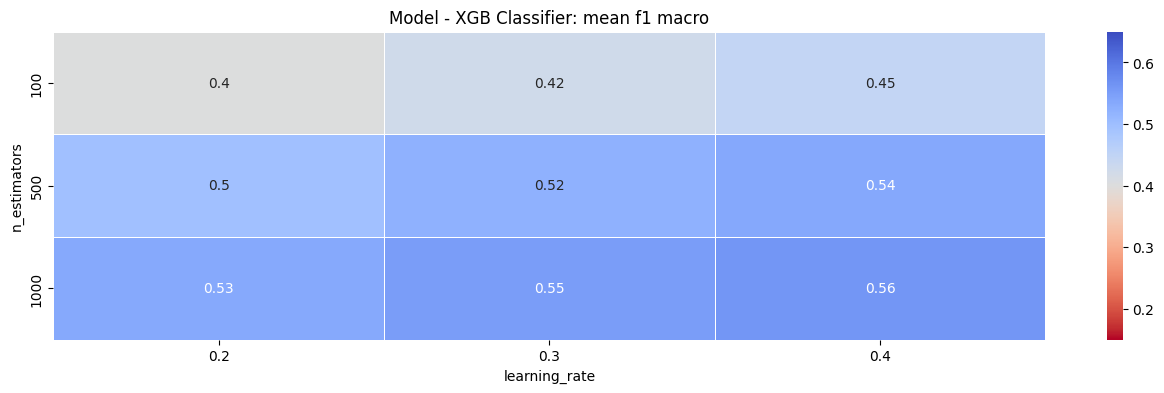

In [31]:
plot_tuning_results_xgbc(df_grid_xgbc)

In [32]:
# Store best Hyperparameters in a variable
best_param_grid_xgbc = grid_search_xgbc.best_params_

# Select best hyperparameters for optimized model training
best_params_xgbc = dict(learning_rate = best_param_grid_xgbc['learning_rate'], n_estimators = best_param_grid_xgbc['n_estimators']
                         )

print(f"XGBC GridSearch Optimized Hyperparameters: {best_params_xgbc}")

XGBC GridSearch Optimized Hyperparameters: {'learning_rate': 0.4, 'n_estimators': 1000}


#### Tune XGBC model cv:

In [33]:
# Evaluate model with cross validation using F1 macro score
f1_scorer = make_scorer(f1_score, average='macro')

# Start measuring time
start_time = time.time()
tune_xgbc_cv = xgb.XGBClassifier(**best_params_xgbc, random_state=rand_state, n_jobs=-1, tree_method='hist', device="cuda", num_class=3)   

# Create StratifiedKFold object for stratified cross-validation
skf = StratifiedKFold(n_splits=numb_split, shuffle=True, random_state=rand_state )

# Measure traininig time
start_time = time.time()
tune_xgbc_cv_results = cross_validate(tune_xgbc_cv, X_train_trans, y_train_le, cv=skf, scoring=f1_scorer, return_train_score=True, return_estimator=True)
end_time = time.time()
tune_xgbc_train_time = end_time - start_time

In [ ]:
# Print the cross-validation training time and scores:
print(f"Tune XGBC training time: {tune_xgbc_train_time} seconds for K-fold: {numb_split}\n")

In [35]:
# Train performance
print(f"Tune XGBC Cross-val Mean f1 macro train_score: {np.mean(tune_xgbc_cv_results['train_score'])}")
print(f"Tune XGBC Cross-val Standard Deviation of f1 macro train_score: {np.std(tune_xgbc_cv_results['train_score'])}\n")

Tune XGBC Cross-val Mean f1 macro train_score: 0.6511797129405621
Tune XGBC Cross-val Standard Deviation of f1 macro train_score: 0.0005143409966598092



In [36]:
# Validation performance
print(f"Tune XGBC Cross-val Mean f1 macro val_score: {np.mean(tune_xgbc_cv_results['test_score'])}")
print(f"Tune XGBC Cross-val Standard Deviation of f1 macro val_score: {np.std(tune_xgbc_cv_results['test_score'])}")

Tune XGBC Cross-val Mean f1 macro val_score: 0.5613974645723454
Tune XGBC Cross-val Standard Deviation of f1 macro val_score: 0.0005656658905796099


#### Tune XGBC Test performance

In [20]:
best_params_xgbc = {'learning_rate':0.4,'n_estimators':1000}

#GridSearch hyperparameter XGB Classifier model: 
tune_xgbc = xgb.XGBClassifier(**best_params_xgbc, random_state=rand_state, n_jobs=-1, tree_method='hist', device="cuda", num_class=3)     

# Fit model with entire training dataset
tune_xgbc.fit(X_train_trans, y_train_le)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=-1, num_class=3,
              num_parallel_tree=None, ...)

In [21]:
# Make predictions on the test dataset
tune_xgbc_pred = tune_xgbc.predict(X_test_trans)

tune_xgbc_f1_score = f1_score(y_test_le, tune_xgbc_pred, average=None)
print(f"XGBC model F1 score: {tune_xgbc_f1_score}")

XGBC model F1 score: [0.35201185 0.7458867  0.60776199]



Tune Model - XGBC  f1 macro score: 0.5685535136728713

Tune Model - XGBC  precision macro score: 0.6794707318309818

Tune Model - XGBC  recall macro score: 0.5420708899183752

Tune Model - XGBC  balanced accuracy score: 0.5420708899183752

Tune Model - XGBC  accuracy score: 0.673693712132543

Tune Model - XGBC  cohen kappa score: 0.3857813999699996

Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.24      0.35     36280
           1       0.67      0.83      0.75    202822
           2       0.67      0.56      0.61    141997

    accuracy                           0.67    381099
   macro avg       0.68      0.54      0.57    381099
weighted avg       0.67      0.67      0.66    381099




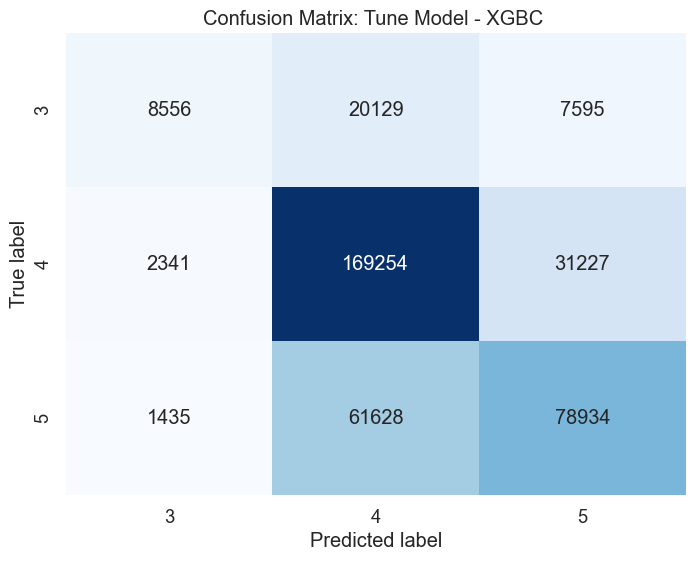

In [20]:
conf_matrix_classif_report('Tune Model - XGBC ',y_test_le, tune_xgbc_pred)

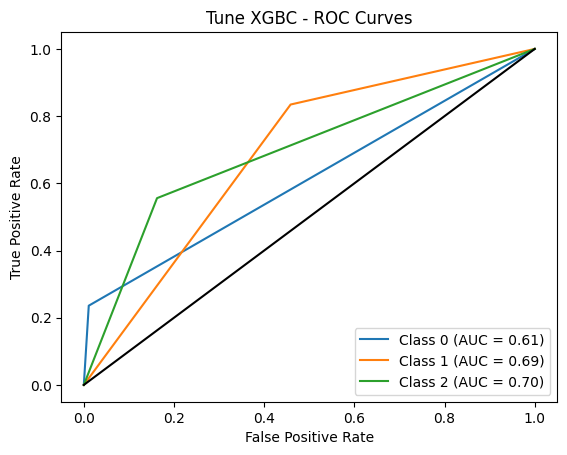

In [24]:
# Test performance
roc_curves("Tune XGBC", y_train_le, y_test_le, tune_xgbc_pred) 

### SHAP Feature Importance

In [20]:
model_feature_names = ['holiday_type_local_holiday_in_the_city_of_madrid',
 'holiday_type_madrid_community_public_holiday',
 'holiday_type_national_holiday',
 'holiday_type_weekend',
 'holiday_type_workingday',
 'travel_time',
 'idunplug_latitude',
 'idunplug_longitude',
 'unplug_station_tot_bases',
 'idplug_latitude',
 'idplug_longitude',
 'plug_station_tot_bases',
 'tot_trips_day',
 'travel_revenue',
 'mh_distance_meters',
 '81',
 '82',
 '83',
 '86',
 '87',
 '88',
 '89',
 'month',
 'day',
 'hour',
 'time_group',
 'day_of_week']

In [21]:
X_test_trans[5]


array([ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.34741523,  0.62838952,  0.38238132,  0.66666667,  0.81780077,
        0.37099912,  0.66666667,  0.10526316,  0.25      ,  0.16405174,
        0.84716981,  0.60055866,  0.29787234,  0.90789474,  0.21621622,
        0.20967742,  0.03571429,  1.        , 31.        , 13.        ,
        2.        ,  3.        ])

In [22]:
# Select stratified sample size
sub_X_train_bad, sub_X_test, sub_y_train_bad, sub_y_test = train_test_split(X_test_trans, y_test_le, test_size = 0.0008, stratify=y_test, random_state = rand_state)

In [23]:
# Summarize data using k-means due to computational limitations
summary_test_background = shap.kmeans(sub_X_test, 3)

# Create an explainer using SHAP Kernel with summarize sub_test data
kernel_explainer = shap.KernelExplainer(tune_xgbc.predict,summary_test_background)

# Compute SHAP valuse for the test data:
shap_val_test_kernel = kernel_explainer.shap_values(sub_X_test)

100%|██████████| 305/305 [01:35<00:00,  3.21it/s]


In [24]:
# Display random selected samples:
y_shap_sub_test = pd.DataFrame(sub_y_test)
y_shap_sub_test.value_counts()

0
1    162
2    114
0     29
Name: count, dtype: int64

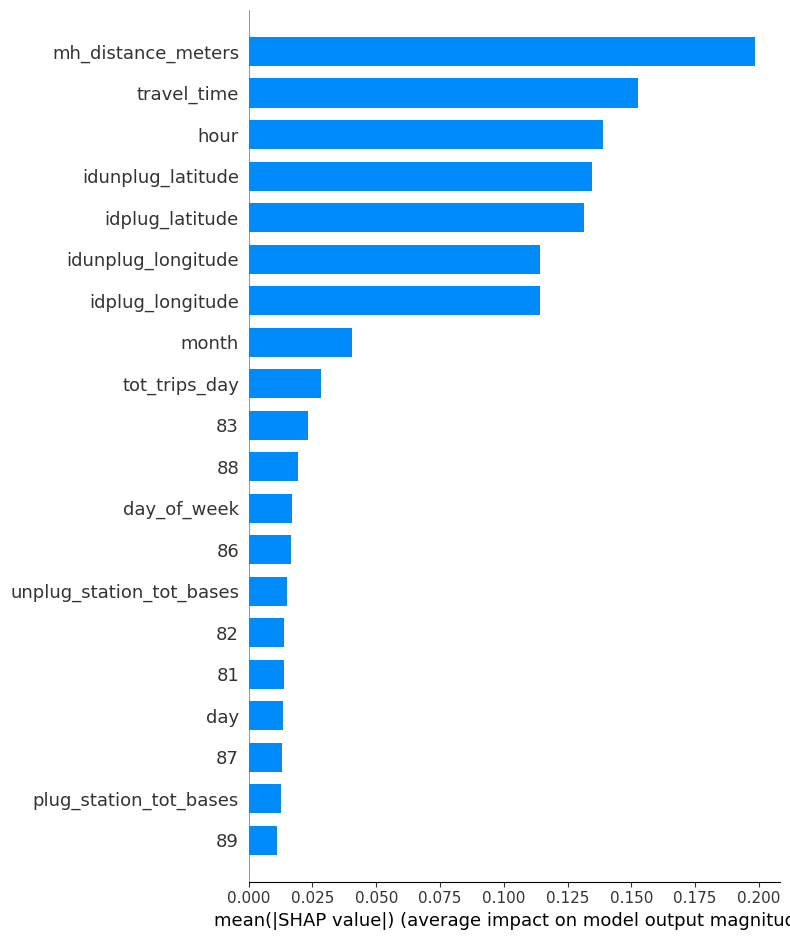

In [25]:
# Plot Shap Values Feature importance
shap.summary_plot(shap_val_test_kernel, feature_names=model_feature_names, plot_type='bar')

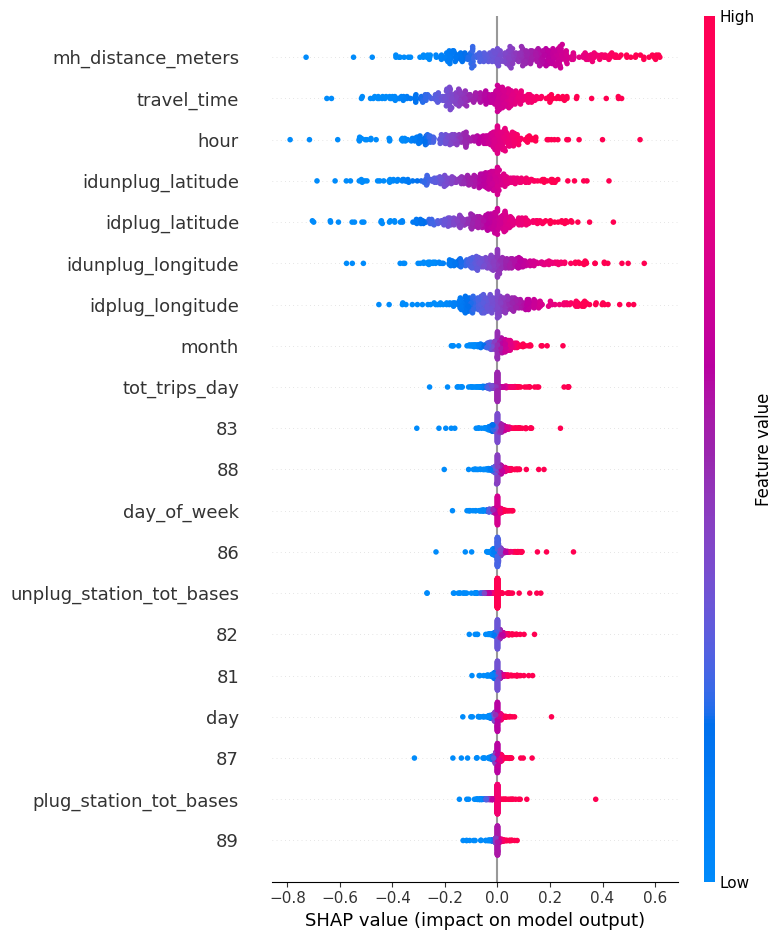

In [26]:
# Plot the aggregated SHAP values for the top ten features 
shap.summary_plot(shap_val_test_kernel,features=shap_val_test_kernel, feature_names=model_feature_names)

## Performance degradation:

In [27]:
feat_impo_test = pd.DataFrame(X_test_trans, columns=model_feature_names)
display(feat_impo_test.head())

,holiday_type_local_holiday_in_the_city_of_madrid,holiday_type_madrid_community_public_holiday,holiday_type_national_holiday,holiday_type_weekend,holiday_type_workingday,travel_time,idunplug_latitude,idunplug_longitude,unplug_station_tot_bases,idplug_latitude,idplug_longitude,plug_station_tot_bases,tot_trips_day,travel_revenue,mh_distance_meters,81,82,83,86,87,88,89,month,day,hour,time_group,day_of_week
0,0.0,0.0,0.0,0.0,1.0,0.148416,0.398492,0.754518,0.666667,0.512957,0.772087,0.666667,0.052632,0.25,0.106578,0.158491,0.000000,0.868794,0.210526,0.648649,0.685484,0.0,9.0,3.0,12.0,2.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.722068,0.244222,0.297815,0.500000,0.574514,0.057344,0.666667,0.052632,0.25,0.439799,0.316981,0.368715,0.680851,0.197368,0.405405,0.946237,0.0,6.0,13.0,20.0,4.0,3.0
2,0.0,0.0,0.0,0.0,1.0,0.561979,0.574514,0.057344,0.666667,0.408725,0.040578,0.833333,0.000000,0.25,0.148313,0.047170,0.620112,0.453901,0.776316,0.621622,0.333333,0.0,10.0,29.0,13.0,2.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.315731,0.225617,0.452899,0.666667,0.432411,0.436571,0.666667,0.052632,0.25,0.181746,0.230189,0.625698,0.960993,0.039474,0.540541,0.887097,0.0,8.0,3.0,18.0,3.0,5.0
4,0.0,0.0,0.0,0.0,1.0,0.617009,0.527184,0.366098,0.666667,0.006227,0.397397,0.833333,0.052632,0.25,0.450985,0.513208,0.620112,0.652482,0.078947,0.486486,0.991935,0.0,6.0,14.0,14.0,2.0,4.0


### Calculate SHAP Feature Importance 

In [28]:
# Calculate mean values from shap_values to extract most important feature list
vals_shap = np.abs(shap_val_test_kernel).mean(0)
vals_shap

# Store shap feature importance values in dataframe
feature_importance = pd.DataFrame(list(zip(model_feature_names, vals_shap)), columns=['col_name', 'feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)

In [29]:
# List Feature importance order desc
rows_list_full = []
for index, row in feature_importance.iterrows():
    rows_list_full.append(row['col_name'])
rows_list_full

['mh_distance_meters',
 'travel_time',
 'hour',
 'idunplug_latitude',
 'idplug_latitude',
 'idunplug_longitude',
 'idplug_longitude',
 'month',
 'tot_trips_day',
 '83',
 '88',
 'day_of_week',
 '86',
 'unplug_station_tot_bases',
 '82',
 '81',
 'day',
 '87',
 'plug_station_tot_bases',
 '89',
 'holiday_type_workingday',
 'time_group',
 'holiday_type_weekend',
 'travel_revenue',
 'holiday_type_national_holiday',
 'holiday_type_madrid_community_public_holiday',
 'holiday_type_local_holiday_in_the_city_of_madrid']

In [30]:
# Model performance degradation:
# Create a copy of the test data to modify
test_asdf = feat_impo_test.copy(deep=True)

# Store original F1 score with unmodified data
original_pred = tune_xgbc.predict(test_asdf)
original_f1 = f1_score(y_test_le, original_pred, average='macro')

# Initialize a list to store F1 scores after each feature modification
f1_scores_xgbc = [original_f1]

In [31]:
perf_deg_tune_xgbc = feat_impo_test.copy(deep=True)

# Review Feature Importance and select top 10 taking into account ohe, pairwise feat, numerical and categorical
top_feat_imp_tune_xgbc = ['mh_distance_meters',
 'travel_time',
 'hour',
 'idunplug_latitude',
 'idplug_latitude',
 'month',
 'tot_trips_day',
 '83',
 '88',
 '86']


# [1] Feature Importance marginalized
mh_mean = perf_deg_tune_xgbc['mh_distance_meters'].mean()
perf_deg_tune_xgbc['mh_distance_meters'] = mh_mean

# Store Feature [1] marginalized F1 score with unmodified data
mh_pred = tune_xgbc.predict(perf_deg_tune_xgbc)
mh_pred_f1 = f1_score(y_test_le, mh_pred, average='macro')
f1_scores_xgbc.append(mh_pred_f1)

# [1, 2] Feature Importance marginalized
trav_time_mean = perf_deg_tune_xgbc['travel_time'].mean()
perf_deg_tune_xgbc['travel_time'] = trav_time_mean

# Store Feature [1, 2] marginalized F1 score with unmodified data
trav_time_pred = tune_xgbc.predict(perf_deg_tune_xgbc)
trav_time_f1 = f1_score(y_test_le, trav_time_pred, average='macro')
f1_scores_xgbc.append(trav_time_f1)

# [1, 2, 3] Feature Importance marginalized
mode_value_hour = perf_deg_tune_xgbc['hour'].mode()[0]  # Calculate mode
perf_deg_tune_xgbc['hour'] = mode_value_hour

# Store Feature [1, 2, 3] marginalized F1 score with unmodified data
hour_pred = tune_xgbc.predict(perf_deg_tune_xgbc)
hour_pred_f1 = f1_score(y_test_le, hour_pred, average='macro')
f1_scores_xgbc.append(hour_pred_f1)

# [1,2,3,4] Feature Importance marginalized
mode_value_lat = perf_deg_tune_xgbc['idunplug_latitude'].mode()[0]  # Calculate mode
perf_deg_tune_xgbc['idunplug_latitude'] = mode_value_lat

mode_value_lon = perf_deg_tune_xgbc['idunplug_longitude'].mode()[0]  # Calculate mode
perf_deg_tune_xgbc['idunplug_longitude'] = mode_value_lon

# Store Feature [1,2,3,4] marginalized F1 score with unmodified data
idunplug_pred = tune_xgbc.predict(perf_deg_tune_xgbc)
idunplug_pred_f1 = f1_score(y_test_le, idunplug_pred, average='macro')
f1_scores_xgbc.append(idunplug_pred_f1)

# Store Feature [1,2,3,4,5] marginalized F1 score with unmodified data
mode_value_lat = perf_deg_tune_xgbc['idplug_latitude'].mode()[0]  # Calculate mode
perf_deg_tune_xgbc['idplug_latitude'] = mode_value_lat

mode_value_lon = perf_deg_tune_xgbc['idplug_longitude'].mode()[0]  # Calculate mode
perf_deg_tune_xgbc['idplug_longitude'] = mode_value_lon

# Store Feature [1,2,3,4,5] marginalized F1 score with unmodified data
idplug_pred = tune_xgbc.predict(perf_deg_tune_xgbc)
idplug_pred_f1 = f1_score(y_test_le, idplug_pred, average='macro')
f1_scores_xgbc.append(idplug_pred_f1)

# [1,2,3,4,5,6] Feature Importance marginalized
mode_value_month = perf_deg_tune_xgbc['month'].mode()[0]  # Calculate mode
perf_deg_tune_xgbc['month'] = mode_value_month

# Store Feature [1,2,3,4,5,6] marginalized F1 score with unmodified data
month_pred = tune_xgbc.predict(perf_deg_tune_xgbc)
month_pred_f1 = f1_score(y_test_le, month_pred, average='macro')
f1_scores_xgbc.append(month_pred_f1)

# Store Feature [1,2,3,4,5,6,7] marginalized F1 score with unmodified data
mean_tot_trips_day = perf_deg_tune_xgbc['tot_trips_day'].mean()
perf_deg_tune_xgbc['tot_trips_day'] = mean_tot_trips_day

# Store Feature [1,2,3,4,5,6,7] marginalized F1 score with unmodified data
pred_tot_trips_day = tune_xgbc.predict(perf_deg_tune_xgbc)
pred_tot_trips_day_f1 = f1_score(y_test_le, pred_tot_trips_day, average='macro')
f1_scores_xgbc.append(pred_tot_trips_day_f1)


# Store Feature [1,2,3,4,5,6,7,8] marginalized F1 score with unmodified data
mean_83 = perf_deg_tune_xgbc['83'].mean()
perf_deg_tune_xgbc['83'] = mean_83

# Store Feature [1,2,3,4,5,6,7,8] marginalized F1 score with unmodified data
pred_83 = tune_xgbc.predict(perf_deg_tune_xgbc)
pred_83_f1 = f1_score(y_test_le, pred_83, average='macro')
f1_scores_xgbc.append(pred_83_f1)

# Store Feature [1,2,3,4,5,6,7,8,9] marginalized F1 score with unmodified data
mean_88 = perf_deg_tune_xgbc['88'].mean()
perf_deg_tune_xgbc['88'] = mean_88

# Store Feature [1,2,3,4,5,6,7,8,9] marginalized F1 score with unmodified data
pred_88 = tune_xgbc.predict(perf_deg_tune_xgbc)
pred_88_f1 = f1_score(y_test_le, pred_88, average='macro')
f1_scores_xgbc.append(pred_88_f1)

# [1,2,3,4,5,6,7,8,9,10] Feature Importance marginalized
mean_86 = perf_deg_tune_xgbc['86'].mean()
perf_deg_tune_xgbc['86'] = mean_86

# Store Feature [1,2,3,4,5,6,7,8,9,10] marginalized F1 score with unmodified data
pred_86 = tune_xgbc.predict(perf_deg_tune_xgbc)
pred_86_f1 = f1_score(y_test_le, pred_86, average='macro')
f1_scores_xgbc.append(pred_86_f1)

In [32]:
f1_scores_xgbc

[0.5685535136728713,
 0.4722345169726984,
 0.46162586312171,
 0.38838162355099404,
 0.28768434000095067,
 0.23360676851660359,
 0.23341020768729515,
 0.23169824428915806,
 0.2316068857796173,
 0.23160982081569892,
 0.23159239250753638]

In [43]:
perf_deg_tune_xgbc.head()

,holiday_type_local_holiday_in_the_city_of_madrid,holiday_type_madrid_community_public_holiday,holiday_type_national_holiday,holiday_type_weekend,holiday_type_workingday,travel_time,idunplug_latitude,idunplug_longitude,unplug_station_tot_bases,idplug_latitude,idplug_longitude,plug_station_tot_bases,tot_trips_day,travel_revenue,mh_distance_meters,81,82,83,86,87,88,89,month,day,hour,time_group,day_of_week
0,0.0,0.0,0.0,0.0,1.0,0.388325,0.574196,0.333952,0.666667,0.574196,0.333952,0.666667,0.06181,0.25,0.269556,0.158491,0.000000,0.510465,0.412518,0.648649,0.560063,0.0,6.0,3.0,18.0,2.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.388325,0.574196,0.333952,0.500000,0.574196,0.333952,0.666667,0.06181,0.25,0.269556,0.316981,0.368715,0.510465,0.412518,0.405405,0.560063,0.0,6.0,13.0,18.0,4.0,3.0
2,0.0,0.0,0.0,0.0,1.0,0.388325,0.574196,0.333952,0.666667,0.574196,0.333952,0.833333,0.06181,0.25,0.269556,0.047170,0.620112,0.510465,0.412518,0.621622,0.560063,0.0,6.0,29.0,18.0,2.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.388325,0.574196,0.333952,0.666667,0.574196,0.333952,0.666667,0.06181,0.25,0.269556,0.230189,0.625698,0.510465,0.412518,0.540541,0.560063,0.0,6.0,3.0,18.0,3.0,5.0
4,0.0,0.0,0.0,0.0,1.0,0.388325,0.574196,0.333952,0.666667,0.574196,0.333952,0.833333,0.06181,0.25,0.269556,0.513208,0.620112,0.510465,0.412518,0.486486,0.560063,0.0,6.0,14.0,18.0,2.0,4.0


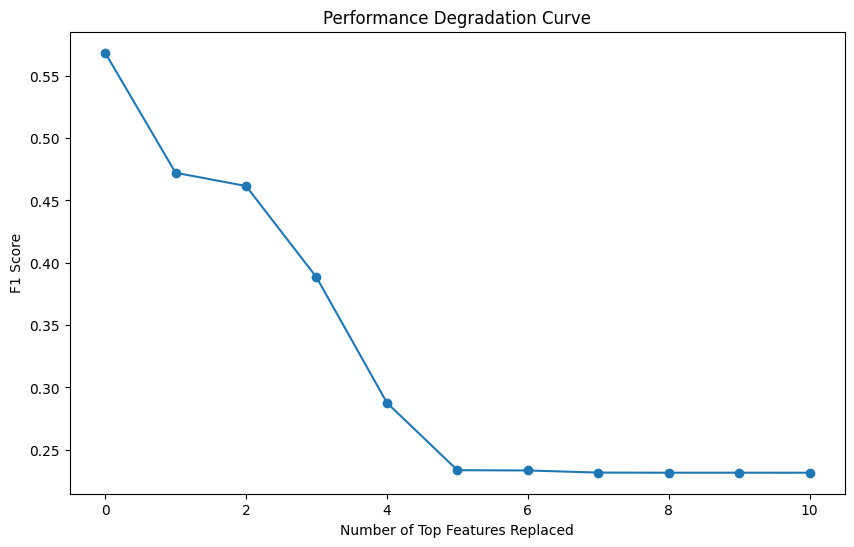

In [44]:
# Plot the performance degradation curve
plt.figure(figsize=(10, 6))
plt.plot(range(len(f1_scores_xgbc)), f1_scores_xgbc, marker='o')
plt.title('Performance Degradation Curve')
plt.xlabel('Number of Top Features Replaced')
plt.ylabel('F1 Score')
plt.grid(False)


Performance Degradation After Top 10 - XGBC f1 macro score: 0.23159239250753638

Performance Degradation After Top 10 - XGBC precision macro score: 0.3592216511830879

Performance Degradation After Top 10 - XGBC recall macro score: 0.33334248770633185

Performance Degradation After Top 10 - XGBC balanced accuracy score: 0.33334248770633185

Performance Degradation After Top 10 - XGBC accuracy score: 0.5322107903720555

Performance Degradation After Top 10 - XGBC cohen kappa score: 2.6675338592463405e-05

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     36280
           1       0.53      1.00      0.69    202822
           2       0.55      0.00      0.00    141997

    accuracy                           0.53    381099
   macro avg       0.36      0.33      0.23    381099
weighted avg       0.49      0.53      0.37    381099




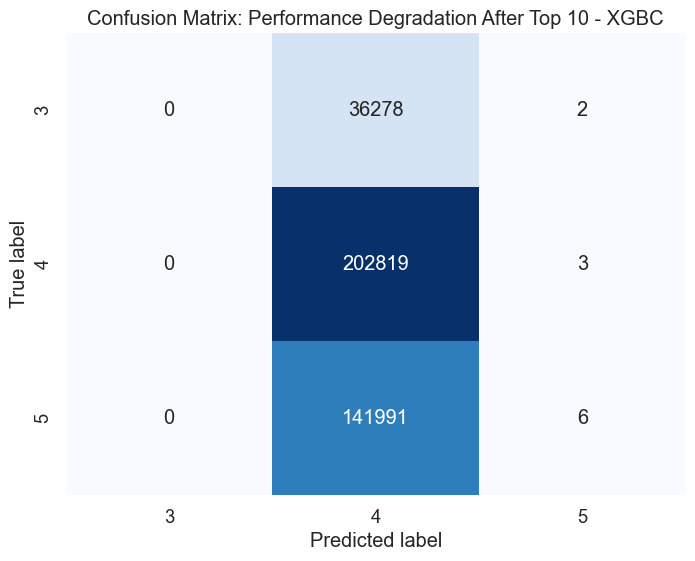

In [33]:
# Error analysis Performance degradation after top 10 features marginalized
conf_matrix_classif_report('Performance Degradation After Top 10 - XGBC', y_test_le, pred_86)

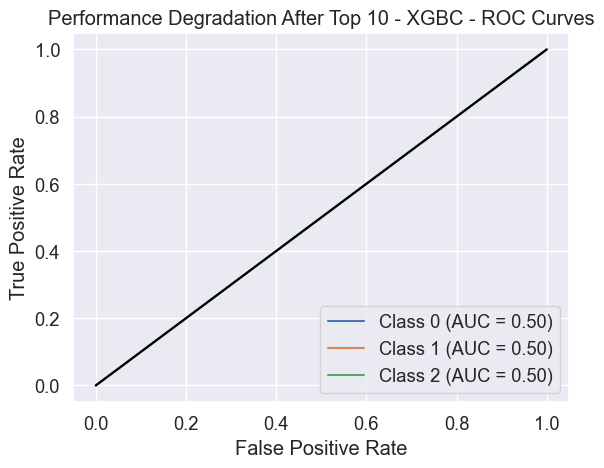

In [34]:
# Error analysis Performance degradation after top 10 features marginalized
roc_curves("Performance Degradation After Top 10 - XGBC", y_train_le, y_test_le, pred_86) 

## Model XGBC optimization Optuna (RandomSearch)

In [23]:
numb_split = 5
rand_state = 123

# Create StratifiedKFold object for stratified cross-validation
skf = StratifiedKFold(n_splits=numb_split, shuffle=True, random_state=rand_state)

def objective_xgbc(trial):
    eta = trial.suggest_loguniform('eta', 0.001, 0.3)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=20)
  
    
    xgbc_params = dict(eta = eta, n_estimators = n_estimators)

    xgbc_opt = xgb.XGBClassifier(**xgbc_params, random_state=rand_state, n_jobs=-1, tree_method='hist', device="cuda", num_class=4)  
    score_xgbc = cross_val_score(xgbc_opt, X_train_trans, y_train_le, cv=skf, scoring='f1_macro') # Update X and y
    f1_macro_xgbc = score_xgbc.mean()    
    return float(f1_macro_xgbc)

In [ ]:
study_xgbc = optuna.create_study(directions=['maximize'])
study_xgbc.optimize(objective_xgbc, n_trials=30)

<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

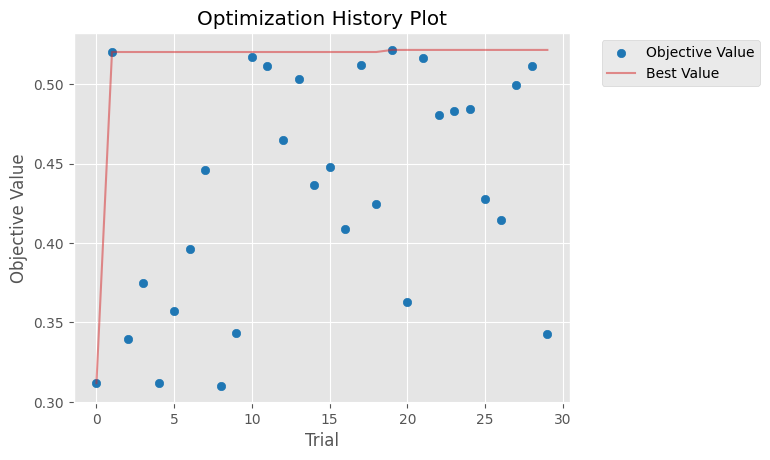

In [25]:
optuna.visualization.matplotlib.plot_optimization_history(study_xgbc)

In [26]:
xgbc_params = study_xgbc.best_params
print(xgbc_params)

{'eta': 0.2742635802086803, 'n_estimators': 600}


In [27]:
best_params_xgbc = dict(eta =xgbc_params['eta'], n_estimators = xgbc_params['n_estimators']
                         )

print(f"XGB Classifier Optimized Hyperparameters: {best_params_xgbc}")

XGB Classifier Optimized Hyperparameters: {'eta': 0.2742635802086803, 'n_estimators': 600}


In [28]:
#Optuna optimized XGB Classifier model: 
opt_mod_xgbc = xgb.XGBClassifier(**best_params_xgbc, random_state=rand_state, n_jobs=-1, tree_method='hist', device="cuda", num_class=4)     

# Fit model with entire training dataset
opt_mod_xgbc.fit(X_train_trans,y_train_le)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eta=0.2742635802086803,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=-1, num_class=4, ...)

In [29]:
# Make predictions on the test dataset
opt_mod_xgbc_pred = opt_mod_xgbc.predict(X_test_trans)

opt_mod_xgbc_f1_score = f1_score(y_test_le, opt_mod_xgbc_pred, average=None)
print(f"XGBC model F1 score: {opt_mod_xgbc_f1_score}")

XGBC model F1 score: [0.2730556  0.73118686 0.56616312]


In [30]:
print(classification_report(y_test_le, opt_mod_xgbc_pred))
print(confusion_matrix(y_test_le, opt_mod_xgbc_pred))

              precision    recall  f1-score   support

           0       0.71      0.17      0.27     38462
           1       0.64      0.84      0.73    210656
           2       0.66      0.50      0.57    149171

    accuracy                           0.65    398289
   macro avg       0.67      0.50      0.52    398289
weighted avg       0.66      0.65      0.63    398289

[[  6502  24181   7779]
 [  1697 177976  30983]
 [   963  74001  74207]]


## XGBC with SMOTE

In [48]:
# Example from stackoverflow: https://stackoverflow.com/questions/50245684/using-smote-with-gridsearchcv-in-scikit-learn
# How to call parameters in Pipeline: https://stackoverflow.com/questions/58815016/cross-validating-with-imblearn-pipeline-and-gridsearchcv

numb_split = 5
rand_state = 123

# Define the scoring metric as F1 score macro
scoring = make_scorer(f1_score, average='macro')

# Start measuring time
start_time = time.time()

# Create XGB classifier
xgbc = xgb.XGBClassifier(random_state=rand_state, n_jobs=-1, tree_method='hist', device="cuda" )

# Create StratifiedKFold object for stratified cross-validation
skf = StratifiedKFold(n_splits=numb_split, shuffle=True, random_state=rand_state)

# Create a pipeline with SMOTE and XGBC
pipeline = Pipeline([
    ('smote', SMOTE(random_state=rand_state, n_jobs=-1)),
    ('xgbc', xgbc)
])

# Define the hyperparameters and their possible values 
param_grid_xgbc_smote = {'xgbc__learning_rate': [0.2, 0.3, 0.4], # xgbc default learning rate: 0.3
                   'xgbc__n_estimators': [100, 500, 1000] 
              }

# Create a grid search object
grid_search_xgbc_smote = GridSearchCV(estimator=pipeline, param_grid=param_grid_xgbc_smote, scoring=scoring, cv=skf)

# Fit the grid search to your data
grid_search_xgbc_smote.fit(X_train_trans, y_train_le)

# Calculate elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Print the best hyperparameters
print(f"Elapsed time: {elapsed_time} seconds")
print(f"Best Hyperparameters: {grid_search_xgbc_smote.best_params_}")
print(f"Best performance: {grid_search_xgbc_smote.best_score_}")

Elapsed time: 16207.92564868927 seconds
Best Hyperparameters: {'xgbc__learning_rate': 0.4, 'xgbc__n_estimators': 1000}
Best performance: 0.5475881518894404


In [49]:
def plot_tuning_results_xgbc_smote(df_val):

    pivot1 = df_val.pivot_table(index='xgbc__n_estimators',columns='xgbc__learning_rate',values='mean_f1_macro')
    
    plt.subplots(1, 1, figsize=(16,4))

    sns.heatmap(pivot1,vmin=0.10,vmax=0.65,annot=True,linewidths=0.4,cmap="coolwarm_r") # changed from vmin=0.45
    plt.title("Tuned Model - XGBC with SMOTE: mean f1 macro")


In [50]:
df_grid_xgbc_smote = pd.DataFrame(grid_search_xgbc_smote.cv_results_["params"])
df_grid_xgbc_smote 

,xgbc__learning_rate,xgbc__n_estimators
0,0.2,100
1,0.2,500
2,0.2,1000
3,0.3,100
4,0.3,500
5,0.3,1000
6,0.4,100
7,0.4,500
8,0.4,1000


In [51]:
df_grid_xgbc_smote['mean_f1_macro'] = np.round(grid_search_xgbc_smote.cv_results_["mean_test_score"],3)
df_grid_xgbc_smote['std_f1_macro'] = np.round(grid_search_xgbc_smote.cv_results_["std_test_score"],4)
df_grid_xgbc_smote 


,xgbc__learning_rate,xgbc__n_estimators,mean_f1_macro,std_f1_macro
0,0.2,100,0.413,0.0009
1,0.2,500,0.485,0.0008
2,0.2,1000,0.520,0.0009
3,0.3,100,0.429,0.0013
4,0.3,500,0.507,0.0013
5,0.3,1000,0.537,0.0014
6,0.4,100,0.441,0.0007
7,0.4,500,0.520,0.0011
8,0.4,1000,0.548,0.0009


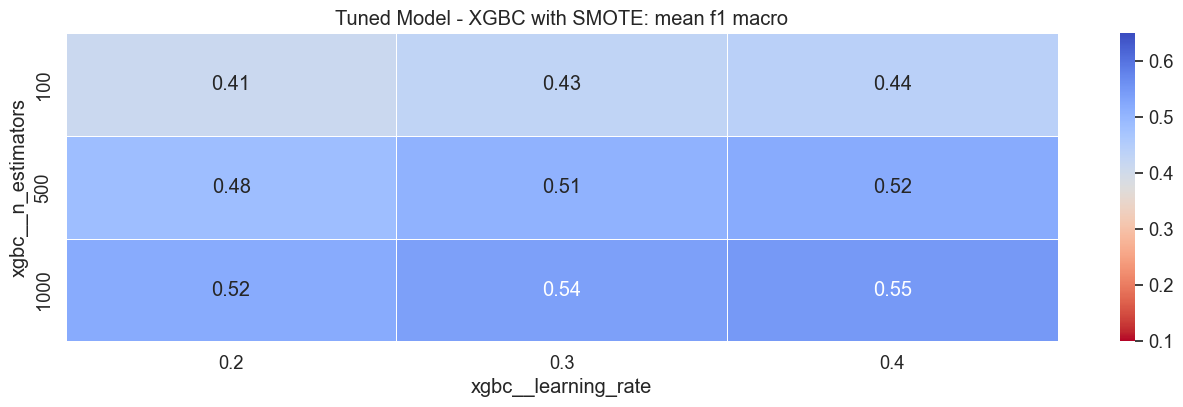

In [52]:
plot_tuning_results_xgbc_smote(df_grid_xgbc_smote)

In [53]:
# Store best Hyperparameters in a variable
best_param_grid_xgbc_smote = grid_search_xgbc_smote.best_params_

# Select best hyperparameters for optimized model training
best_params_xgbc_smote = dict(learning_rate = best_param_grid_xgbc_smote['xgbc__learning_rate'], n_estimators = best_param_grid_xgbc_smote['xgbc__n_estimators']
                         )

print(f"XGBC with SMOTE GridSearch Optimized Hyperparameters: {best_params_xgbc_smote}")

XGBC with SMOTE GridSearch Optimized Hyperparameters: {'learning_rate': 0.4, 'n_estimators': 1000}


#### Tune XGBC with SMOTE model cv:

In [54]:
# Evaluate model with cross validation using F1 macro score
f1_scorer = make_scorer(f1_score, average='macro')

# Start measuring time
start_time = time.time()
tune_xgbc_smote_cv = xgb.XGBClassifier(**best_params_xgbc_smote, random_state=rand_state, n_jobs=-1, tree_method='hist', device="cuda", num_class=3)   

# Create StratifiedKFold object for stratified cross-validation
skf = StratifiedKFold(n_splits=numb_split, shuffle=True, random_state=rand_state )

# Set up pipeline with SMOTE to prevent data leakage 
pipeline_xgbc_smote = Pipeline([
    ('smote', SMOTE(random_state=rand_state, n_jobs=-1)),
    ('opt_tune_logit', tune_xgbc_smote_cv)
])

tune_xgbc_smote_cv_results = cross_validate(pipeline_xgbc_smote, X_train_trans, y_train_le, cv=skf, scoring=f1_scorer, return_train_score=True)
end_time = time.time()
tune_xgbc_smote_train_time = end_time - start_time

In [ ]:
# Print the cross-validation training time and scores:
print(f"Tune XGBC with SMOTE training time: {tune_xgbc_smote_train_time} seconds for K-fold: {numb_split}\n")

In [56]:
# Train performance
print(f"Tune XGBC with SMOTE Cross-val Mean f1 macro train_score: {np.mean(tune_xgbc_smote_cv_results['train_score'])}")
print(f"Tune XGBC with SMOTE Cross-val Standard Deviation of f1 macro train_score: {np.std(tune_xgbc_smote_cv_results['train_score'])}\n")

Tune XGBC with SMOTE Cross-val Mean f1 macro train_score: 0.6190152161070219
Tune XGBC with SMOTE Cross-val Standard Deviation of f1 macro train_score: 0.0007425341168734075



In [57]:
# Validation performance
print(f"Tune XGBC with SMOTE Cross-val Mean f1 macro val_score: {np.mean(tune_xgbc_smote_cv_results['test_score'])}")
print(f"Tune XGBC with SMOTE Cross-val Standard Deviation of f1 macro val_score: {np.std(tune_xgbc_smote_cv_results['test_score'])}")

Tune XGBC with SMOTE Cross-val Mean f1 macro val_score: 0.5475881518894404
Tune XGBC with SMOTE Cross-val Standard Deviation of f1 macro val_score: 0.0008685521852798377


### Tune XGBC wih SMOTE Test performance

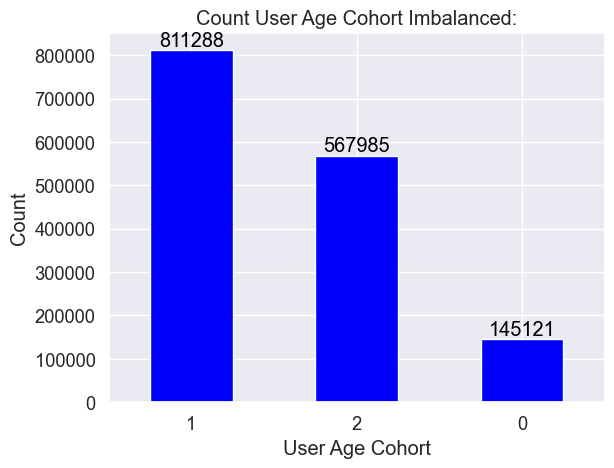

In [58]:
""" User ageRange values active population: {3:[19:26]; 4:[27:40]; 5:[41:65]}"""

# Support dataframe to plot imbalanced age cohort value counts
y_train_df = pd.DataFrame(y_train_le)

# User Age Cohort value counts
user_age_count = y_train_df[0].value_counts()

# Create barplot
ax = user_age_count.plot(kind='bar', rot=0, color=['blue'])

# Add values on top of each bar
for i, v in enumerate(user_age_count):
    ax.text(i, v + 1, v, ha='center', va='bottom', color='black')

plt.xlabel('User Age Cohort')
plt.ylabel('Count')
plt.title('Count User Age Cohort Imbalanced:')

# Show the plot
plt.show()

In [20]:
# Apply SMOTE to the training set
smote = SMOTE(random_state=rand_state, n_jobs=-1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_trans, y_train_le)

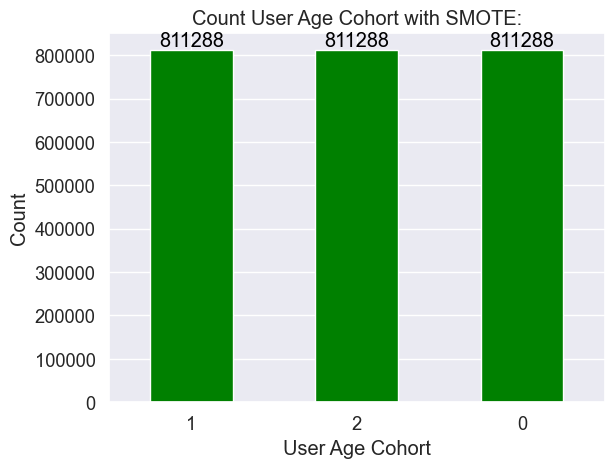

In [60]:
""" User ageRange values active population: {3:[19:26]; 4:[27:40]; 5:[41:65]}"""

# Support dataframe to plot age cohort value counts with SMOTE
y_train_resampled_df = pd.DataFrame(y_train_resampled)

# User Age Cohort value counts
user_age_count_resampled = y_train_resampled_df[0].value_counts()

# Create barplot
ax = user_age_count_resampled.plot(kind='bar', rot=0, color=['green'])

# Add values on top of each bar
for i, v in enumerate(user_age_count_resampled):
    ax.text(i, v + 1, v, ha='center', va='bottom', color='black')

plt.xlabel('User Age Cohort')
plt.ylabel('Count')
plt.title('Count User Age Cohort with SMOTE:')

# Show the plot
plt.show()

In [21]:
best_params_xgbc_smote = {'learning_rate': 0.4, 'n_estimators': 1000}

#GridSearch hyperparameter XGB Classifier model: 
tune_xgbc_smote = xgb.XGBClassifier(**best_params_xgbc_smote, random_state=rand_state, n_jobs=-1, tree_method='hist', device="cuda")     

In [22]:
# Fit model with training smote set
tune_xgbc_smote.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [23]:
# Make predictions on the test dataset
tune_xgbc_smote_pred = tune_xgbc_smote.predict(X_test_trans)

tune_xgbc_smote_f1_score = f1_score(y_test_le, tune_xgbc_smote_pred, average=None)
print(f"Tune XGBC with SMOTE F1 score: {tune_xgbc_smote_f1_score}")

Tune XGBC with SMOTE F1 score: [0.3233264  0.73865632 0.59489128]



Tune Model - XGBC with SMOTE: f1 macro score: 0.5522913293193477

Tune Model - XGBC with SMOTE: precision macro score: 0.6561913440538546

Tune Model - XGBC with SMOTE: recall macro score: 0.5287641215112059

Tune Model - XGBC with SMOTE: balanced accuracy score: 0.5287641215112059

Tune Model - XGBC with SMOTE: accuracy score: 0.6636517020511731

Tune Model - XGBC with SMOTE: cohen kappa score: 0.36561504074957085

Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.22      0.32     36280
           1       0.66      0.83      0.74    202822
           2       0.66      0.54      0.59    141997

    accuracy                           0.66    381099
   macro avg       0.66      0.53      0.55    381099
weighted avg       0.66      0.66      0.65    381099




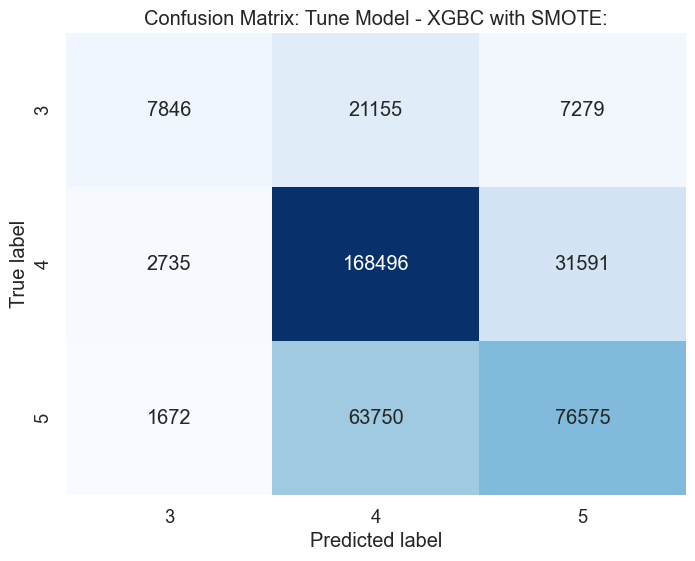

In [25]:
conf_matrix_classif_report('Tune Model - XGBC with SMOTE:', y_test_le, tune_xgbc_smote_pred)

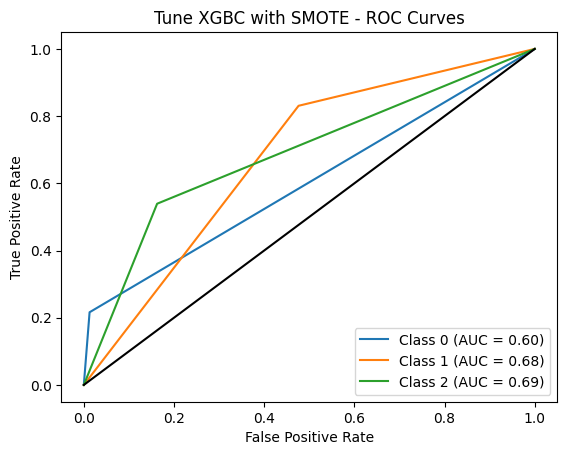

In [29]:
# Test performance
roc_curves("Tune XGBC with SMOTE", y_train_resampled, y_test_le, tune_xgbc_smote_pred) 

### SHAP with SMOTE

In [24]:
# Select stratified sample size
sub_X_train_bad, sub_X_test, sub_y_train_bad, sub_y_test = train_test_split(X_test_trans, y_test_le, test_size = 0.0008, stratify=y_test, random_state = rand_state)

In [25]:
# Summarize data using k-means due to computational limitations
summary_test_background = shap.kmeans(sub_X_test, 3)

# Create an explainer using SHAP Kernel with summarize sub_test data
kernel_explainer = shap.KernelExplainer(tune_xgbc_smote.predict,summary_test_background)

# Compute SHAP valuse for the test data:
shap_val_test_kernel = kernel_explainer.shap_values(sub_X_test)

100%|██████████| 305/305 [01:30<00:00,  3.39it/s]


In [26]:
# Display random selected samples:
y_shap_sub_test = pd.DataFrame(sub_y_test)
y_shap_sub_test.value_counts() 

0
1    162
2    114
0     29
Name: count, dtype: int64

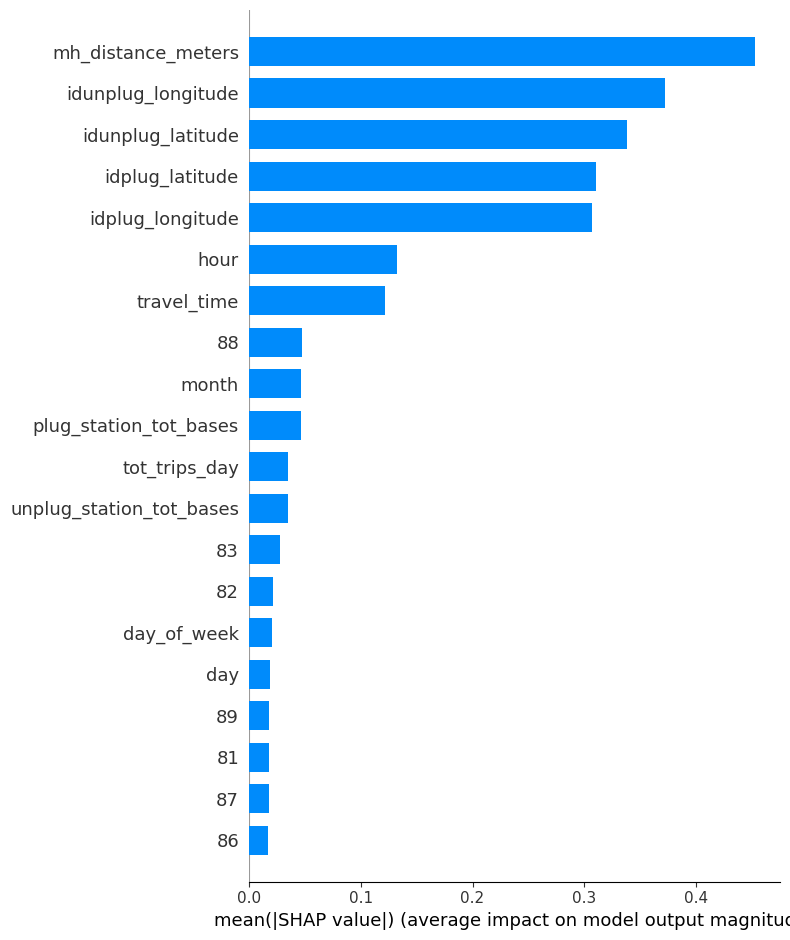

In [27]:
# Plot Shap Values Feature importance
shap.summary_plot(shap_val_test_kernel, feature_names=model_feature_names, plot_type='bar')

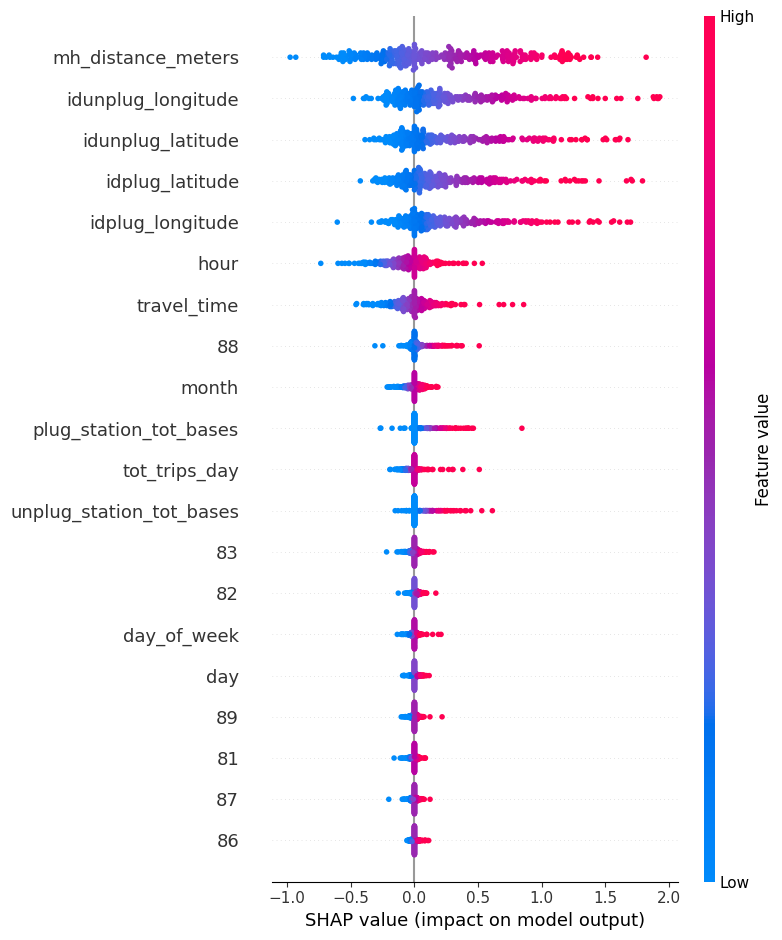

In [28]:
# Plot the aggregated SHAP values for the top ten features 
shap.summary_plot(shap_val_test_kernel,features=shap_val_test_kernel, feature_names=model_feature_names)

## Performance degradation:

In [29]:
feat_impo_test = pd.DataFrame(X_test_trans, columns=model_feature_names)
display(feat_impo_test.head())

,holiday_type_local_holiday_in_the_city_of_madrid,holiday_type_madrid_community_public_holiday,holiday_type_national_holiday,holiday_type_weekend,holiday_type_workingday,travel_time,idunplug_latitude,idunplug_longitude,unplug_station_tot_bases,idplug_latitude,idplug_longitude,plug_station_tot_bases,tot_trips_day,travel_revenue,mh_distance_meters,81,82,83,86,87,88,89,month,day,hour,time_group,day_of_week
0,0.0,0.0,0.0,0.0,1.0,0.148416,0.398492,0.754518,0.666667,0.512957,0.772087,0.666667,0.052632,0.25,0.106578,0.158491,0.000000,0.868794,0.210526,0.648649,0.685484,0.0,9.0,3.0,12.0,2.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.722068,0.244222,0.297815,0.500000,0.574514,0.057344,0.666667,0.052632,0.25,0.439799,0.316981,0.368715,0.680851,0.197368,0.405405,0.946237,0.0,6.0,13.0,20.0,4.0,3.0
2,0.0,0.0,0.0,0.0,1.0,0.561979,0.574514,0.057344,0.666667,0.408725,0.040578,0.833333,0.000000,0.25,0.148313,0.047170,0.620112,0.453901,0.776316,0.621622,0.333333,0.0,10.0,29.0,13.0,2.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.315731,0.225617,0.452899,0.666667,0.432411,0.436571,0.666667,0.052632,0.25,0.181746,0.230189,0.625698,0.960993,0.039474,0.540541,0.887097,0.0,8.0,3.0,18.0,3.0,5.0
4,0.0,0.0,0.0,0.0,1.0,0.617009,0.527184,0.366098,0.666667,0.006227,0.397397,0.833333,0.052632,0.25,0.450985,0.513208,0.620112,0.652482,0.078947,0.486486,0.991935,0.0,6.0,14.0,14.0,2.0,4.0


### Calculate SHAP Feature Importance 

In [30]:
# Calculate mean values from shap_values to extract most important feature list
vals_shap = np.abs(shap_val_test_kernel).mean(0)
vals_shap

# Store shap feature importance values in dataframe
feature_importance = pd.DataFrame(list(zip(model_feature_names, vals_shap)), columns=['col_name', 'feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)

In [31]:
# List Feature importance order desc
rows_list_full = []
for index, row in feature_importance.iterrows():
    rows_list_full.append(row['col_name'])
rows_list_full

['mh_distance_meters',
 'idunplug_longitude',
 'idunplug_latitude',
 'idplug_latitude',
 'idplug_longitude',
 'hour',
 'travel_time',
 '88',
 'month',
 'plug_station_tot_bases',
 'tot_trips_day',
 'unplug_station_tot_bases',
 '83',
 '82',
 'day_of_week',
 'day',
 '89',
 '81',
 '87',
 '86',
 'holiday_type_workingday',
 'time_group',
 'holiday_type_weekend',
 'travel_revenue',
 'holiday_type_local_holiday_in_the_city_of_madrid',
 'holiday_type_madrid_community_public_holiday',
 'holiday_type_national_holiday']

In [32]:
# Model performance degradation:
# Create a copy of the test data to modify
test_asdf = feat_impo_test.copy(deep=True)

# Store original F1 score with unmodified data
original_pred = tune_xgbc_smote.predict(test_asdf)
original_f1 = f1_score(y_test_le, original_pred, average='macro')

# Initialize a list to store F1 scores after each feature modification
f1_scores_xgbc_smote = [original_f1]

In [54]:
f1_scores_xgbc_smote = [original_f1]

In [33]:
perf_deg_tune_xgbc_smote = feat_impo_test.copy(deep=True)

# Review Feature Importance and select top 10 taking into account ohe, pairwise feat, numerical and categorical
top_feat_imp_tune_xgbc_smote = ['mh_distance_meters',
 'idunplug_longitude',
 'idplug_longitude',
 'hour',
 'travel_time',
 '88',
 'month',
 'plug_station_tot_bases',
 'unplug_station_tot_bases',
 'tot_trips_day']


# [1] Feature Importance marginalized
mh_mean = perf_deg_tune_xgbc_smote['mh_distance_meters'].mean()
perf_deg_tune_xgbc_smote['mh_distance_meters'] = mh_mean

# Store Feature [1] marginalized F1 score with unmodified data
mh_pred = tune_xgbc_smote.predict(perf_deg_tune_xgbc_smote)
mh_pred_f1 = f1_score(y_test_le, mh_pred, average='macro')
f1_scores_xgbc_smote.append(mh_pred_f1)

# [1, 2] Feature Importance marginalized
mode_value_lat = perf_deg_tune_xgbc_smote['idunplug_latitude'].mode()[0]  # Calculate mode
perf_deg_tune_xgbc_smote['idunplug_latitude'] = mode_value_lat

mode_value_lon = perf_deg_tune_xgbc_smote['idunplug_longitude'].mode()[0]  # Calculate mode
perf_deg_tune_xgbc_smote['idunplug_longitude'] = mode_value_lon

# Store Feature [1, 2] marginalized F1 score with unmodified data
idunplug_pred = tune_xgbc_smote.predict(perf_deg_tune_xgbc_smote)
idunplug_pred_f1 = f1_score(y_test_le, idunplug_pred, average='macro')
f1_scores_xgbc_smote.append(idunplug_pred_f1)

# [1, 2, 3] Feature Importance marginalized
mode_value_lat = perf_deg_tune_xgbc_smote['idplug_latitude'].mode()[0]  # Calculate mode
perf_deg_tune_xgbc_smote['idplug_latitude'] = mode_value_lat

mode_value_lon = perf_deg_tune_xgbc_smote['idplug_longitude'].mode()[0]  # Calculate mode
perf_deg_tune_xgbc_smote['idplug_longitude'] = mode_value_lon

# Store Feature [1, 2, 3] marginalized F1 score with unmodified data
idplug_pred = tune_xgbc_smote.predict(perf_deg_tune_xgbc_smote)
idplug_pred_f1 = f1_score(y_test_le, idplug_pred, average='macro')
f1_scores_xgbc_smote.append(idplug_pred_f1)

# [1,2,3,4] Feature Importance marginalized
mode_value_hour = perf_deg_tune_xgbc_smote['hour'].mode()[0]  # Calculate mode
perf_deg_tune_xgbc_smote['hour'] = mode_value_hour

# Store Feature [1,2,3,4] marginalized F1 score with unmodified data
hour_pred = tune_xgbc_smote.predict(perf_deg_tune_xgbc_smote)
hour_pred_f1 = f1_score(y_test_le, hour_pred, average='macro')
f1_scores_xgbc_smote.append(hour_pred_f1)

# Store Feature [1,2,3,4,5] marginalized F1 score with unmodified data
trav_time_mean = perf_deg_tune_xgbc_smote['travel_time'].mean()
perf_deg_tune_xgbc_smote['travel_time'] = trav_time_mean

# Store Feature [1,2,3,4,5] marginalized F1 score with unmodified data
trav_time_pred = tune_xgbc_smote.predict(perf_deg_tune_xgbc_smote)
trav_time_f1 = f1_score(y_test_le, trav_time_pred, average='macro')
f1_scores_xgbc_smote.append(trav_time_f1)

# [1,2,3,4,5,6] Feature Importance marginalized
mean_88 = perf_deg_tune_xgbc_smote['88'].mean()
perf_deg_tune_xgbc_smote['88'] = mean_88

# Store Feature [1,2,3,4,5,6] marginalized F1 score with unmodified data
pred_88 = tune_xgbc_smote.predict(perf_deg_tune_xgbc_smote)
pred_88_f1 = f1_score(y_test_le, pred_88, average='macro')
f1_scores_xgbc_smote.append(pred_88_f1)

# Store Feature [1,2,3,4,5,6,7] marginalized F1 score with unmodified data
mode_value_month = perf_deg_tune_xgbc_smote['month'].mode()[0]  # Calculate mode
perf_deg_tune_xgbc_smote['month'] = mode_value_month

# Store Feature [1,2,3,4,5,6,7] marginalized F1 score with unmodified data
month_pred = tune_xgbc_smote.predict(perf_deg_tune_xgbc_smote)
month_pred_f1 = f1_score(y_test_le, month_pred, average='macro')
f1_scores_xgbc_smote.append(month_pred_f1)


# Store Feature [1,2,3,4,5,6,7,8] marginalized F1 score with unmodified data
mean_plug_station_tot_bases = perf_deg_tune_xgbc_smote['plug_station_tot_bases'].mean()
perf_deg_tune_xgbc_smote['plug_station_tot_bases'] = mean_plug_station_tot_bases

# Store Feature [1,2,3,4,5,6,7,8] marginalized F1 score with unmodified data
pred_plug_station_tot_bases = tune_xgbc_smote.predict(perf_deg_tune_xgbc_smote)
pred_plug_station_tot_bases_f1 = f1_score(y_test_le, pred_plug_station_tot_bases, average='macro')
f1_scores_xgbc_smote.append(pred_plug_station_tot_bases_f1)

# Store Feature [1,2,3,4,5,6,7,8,9] marginalized F1 score with unmodified data
mean_unplug_station_tot_bases = perf_deg_tune_xgbc_smote['unplug_station_tot_bases'].mean()
perf_deg_tune_xgbc_smote['unplug_station_tot_bases'] = mean_unplug_station_tot_bases

# Store Feature [1,2,3,4,5,6,7,8,9] marginalized F1 score with unmodified data
pred_unplug_station_tot_bases = tune_xgbc_smote.predict(perf_deg_tune_xgbc_smote)
pred_unplug_station_tot_bases_f1 = f1_score(y_test_le, pred_unplug_station_tot_bases, average='macro')
f1_scores_xgbc_smote.append(pred_unplug_station_tot_bases_f1)

# [1,2,3,4,5,6,7,8,9,10] Feature Importance marginalized
mean_tot_trips_day = perf_deg_tune_xgbc_smote['tot_trips_day'].mean()
perf_deg_tune_xgbc_smote['tot_trips_day'] = mean_tot_trips_day

# Store Feature [1,2,3,4,5,6,7,8,9,10] marginalized F1 score with unmodified data
pred_tot_trips_day = tune_xgbc_smote.predict(perf_deg_tune_xgbc_smote)
pred_tot_trips_day_f1 = f1_score(y_test_le, pred_tot_trips_day, average='macro')
f1_scores_xgbc_smote.append(pred_tot_trips_day_f1)

In [34]:
f1_scores_xgbc_smote

[0.5522913293193477,
 0.45783411327938633,
 0.33621134640925404,
 0.2622192500628578,
 0.25405739692879303,
 0.25318288522649196,
 0.25389197904153127,
 0.254032456056468,
 0.06278048444143368,
 0.057997819054859866,
 0.05794893050840283]

In [35]:
perf_deg_tune_xgbc_smote.head()

,holiday_type_local_holiday_in_the_city_of_madrid,holiday_type_madrid_community_public_holiday,holiday_type_national_holiday,holiday_type_weekend,holiday_type_workingday,travel_time,idunplug_latitude,idunplug_longitude,unplug_station_tot_bases,idplug_latitude,idplug_longitude,plug_station_tot_bases,tot_trips_day,travel_revenue,mh_distance_meters,81,82,83,86,87,88,89,month,day,hour,time_group,day_of_week
0,0.0,0.0,0.0,0.0,1.0,0.388325,0.574196,0.333952,0.663483,0.574196,0.333952,0.664707,0.06181,0.25,0.269556,0.158491,0.000000,0.868794,0.210526,0.648649,0.560063,0.0,6.0,3.0,18.0,2.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.388325,0.574196,0.333952,0.663483,0.574196,0.333952,0.664707,0.06181,0.25,0.269556,0.316981,0.368715,0.680851,0.197368,0.405405,0.560063,0.0,6.0,13.0,18.0,4.0,3.0
2,0.0,0.0,0.0,0.0,1.0,0.388325,0.574196,0.333952,0.663483,0.574196,0.333952,0.664707,0.06181,0.25,0.269556,0.047170,0.620112,0.453901,0.776316,0.621622,0.560063,0.0,6.0,29.0,18.0,2.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.388325,0.574196,0.333952,0.663483,0.574196,0.333952,0.664707,0.06181,0.25,0.269556,0.230189,0.625698,0.960993,0.039474,0.540541,0.560063,0.0,6.0,3.0,18.0,3.0,5.0
4,0.0,0.0,0.0,0.0,1.0,0.388325,0.574196,0.333952,0.663483,0.574196,0.333952,0.664707,0.06181,0.25,0.269556,0.513208,0.620112,0.652482,0.078947,0.486486,0.560063,0.0,6.0,14.0,18.0,2.0,4.0


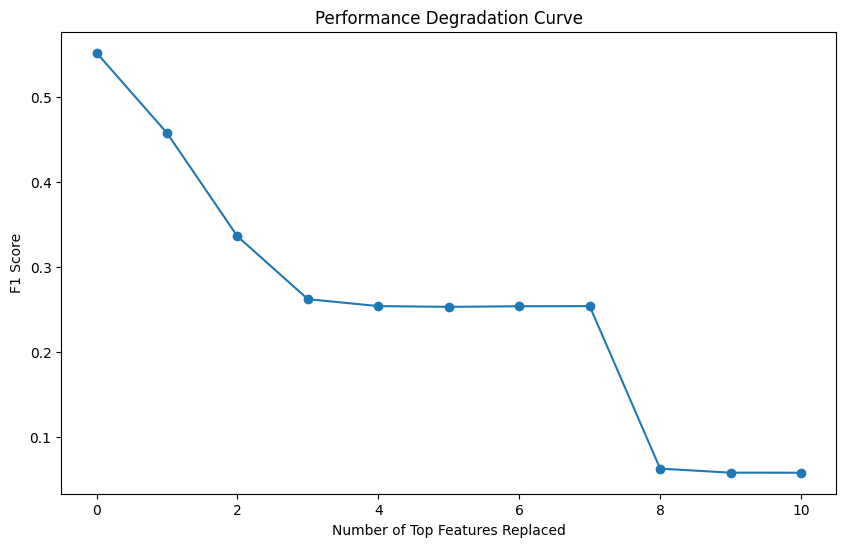

In [60]:
# Plot the performance degradation curve
plt.figure(figsize=(10, 6))
plt.plot(range(len(f1_scores_xgbc_smote)), f1_scores_xgbc_smote, marker='o')
plt.title('Performance Degradation Curve')
plt.xlabel('Number of Top Features Replaced')
plt.ylabel('F1 Score')
plt.grid(False)


Performance Degradation After 4 - XGBC + SMOTE f1 macro score: 0.25318288522649196

Performance Degradation After 4 - XGBC + SMOTE precision macro score: 0.3457690085378069

Performance Degradation After 4 - XGBC + SMOTE recall macro score: 0.3328678322370057

Performance Degradation After 4 - XGBC + SMOTE balanced accuracy score: 0.3328678322370057

Performance Degradation After 4 - XGBC + SMOTE accuracy score: 0.5046011666259949

Performance Degradation After 4 - XGBC + SMOTE cohen kappa score: -0.0006676806654053458

Classification Report:

              precision    recall  f1-score   support

           0       0.09      0.06      0.07     36280
           1       0.53      0.93      0.68    202822
           2       0.41      0.00      0.01    141997

    accuracy                           0.50    381099
   macro avg       0.35      0.33      0.25    381099
weighted avg       0.45      0.50      0.37    381099




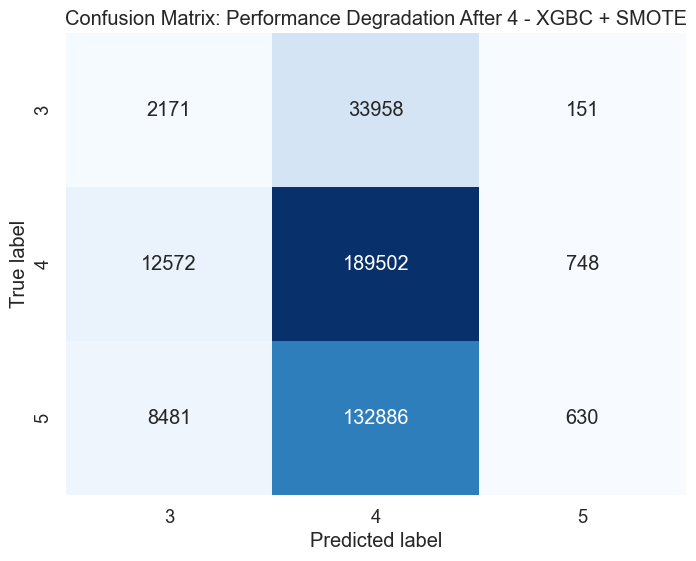

In [38]:
# Error analysis Performance degradation after top 10 features marginalized
conf_matrix_classif_report('Performance Degradation After 4 - XGBC + SMOTE', y_test_le, trav_time_pred)


Performance Degradation After 5 - XGBC + SMOTE f1 macro score: 0.25389197904153127

Performance Degradation After 5 - XGBC + SMOTE precision macro score: 0.34487346723511836

Performance Degradation After 5 - XGBC + SMOTE recall macro score: 0.3309651936192561

Performance Degradation After 5 - XGBC + SMOTE balanced accuracy score: 0.3309651936192561

Performance Degradation After 5 - XGBC + SMOTE accuracy score: 0.49345445671597143

Performance Degradation After 5 - XGBC + SMOTE cohen kappa score: -0.002667091827781354

Classification Report:

              precision    recall  f1-score   support

           0       0.09      0.08      0.08     36280
           1       0.53      0.91      0.67    202822
           2       0.41      0.00      0.01    141997

    accuracy                           0.49    381099
   macro avg       0.34      0.33      0.25    381099
weighted avg       0.45      0.49      0.37    381099




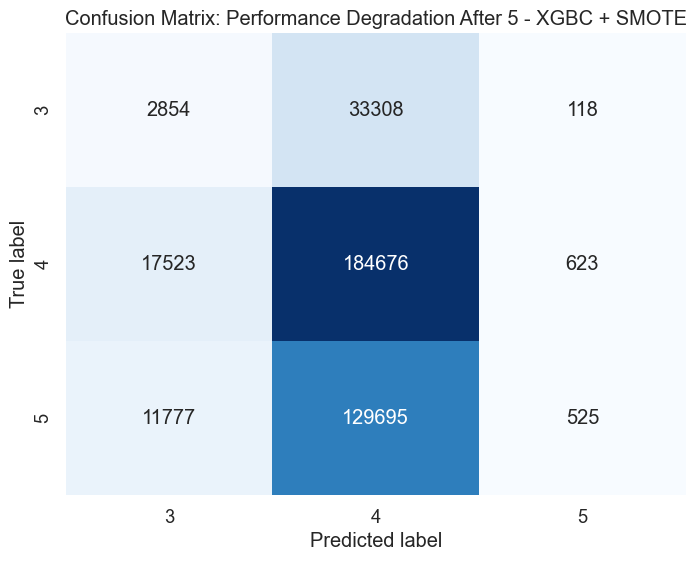

In [39]:
# Error analysis Performance degradation after top 10 features marginalized
conf_matrix_classif_report('Performance Degradation After 5 - XGBC + SMOTE', y_test_le, pred_88)


Performance Degradation After Top 10 - XGBC + SMOTE f1 macro score: 0.05794893050840283

Performance Degradation After Top 10 - XGBC + SMOTE precision macro score: 0.03173278684366355

Performance Degradation After Top 10 - XGBC + SMOTE recall macro score: 0.3333333333333333

Performance Degradation After Top 10 - XGBC + SMOTE balanced accuracy score: 0.3333333333333333

Performance Degradation After Top 10 - XGBC + SMOTE accuracy score: 0.09519836053099064

Performance Degradation After Top 10 - XGBC + SMOTE cohen kappa score: 0.0

Classification Report:

              precision    recall  f1-score   support

           0       0.10      1.00      0.17     36280
           1       0.00      0.00      0.00    202822
           2       0.00      0.00      0.00    141997

    accuracy                           0.10    381099
   macro avg       0.03      0.33      0.06    381099
weighted avg       0.01      0.10      0.02    381099




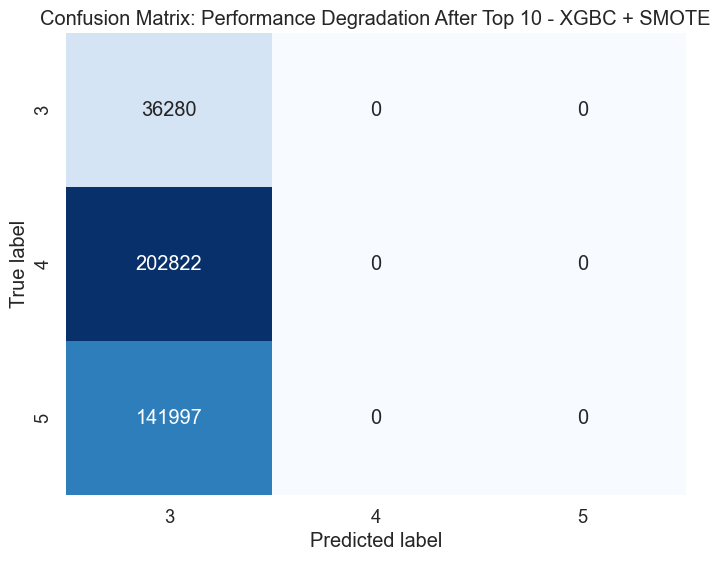

In [50]:
# Error analysis Performance degradation after top 10 features marginalized
conf_matrix_classif_report('Performance Degradation After Top 10 - XGBC + SMOTE', y_test_le, pred_tot_trips_day)

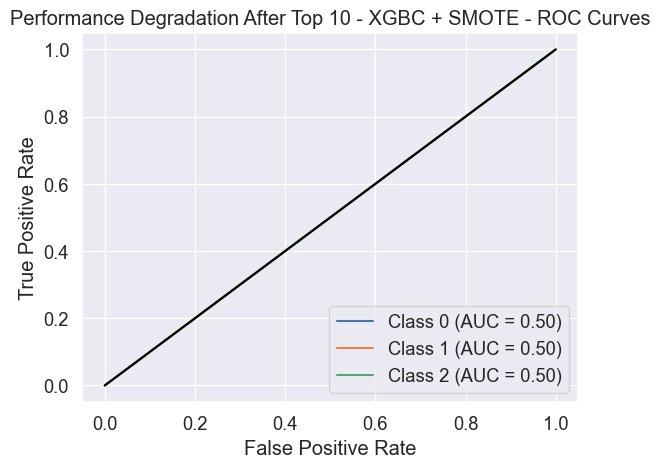

In [51]:
# Error analysis Performance degradation after top 10 features marginalized
roc_curves("Performance Degradation After Top 10 - XGBC + SMOTE", y_train_resampled, y_test_le, pred_tot_trips_day) 

In [61]:
tune_xgbc_f1_deg = [0.5685535136728713,
 0.4722345169726984,
 0.46162586312171,
 0.38838162355099404,
 0.28768434000095067,
 0.23360676851660359,
 0.23341020768729515,
 0.23169824428915806,
 0.2316068857796173,
 0.23160982081569892,
 0.23159239250753638]
 
tune_xgbc_smote_f1_deg = [0.5522913293193477,
 0.45783411327938633,
 0.33621134640925404,
 0.2622192500628578,
 0.25405739692879303,
 0.25318288522649196,
 0.25389197904153127,
 0.254032456056468,
 0.06278048444143368,
 0.057997819054859866,
 0.05794893050840283]


# Create Performance degradation graph tuned XGBC with(out) SMOTE
graph_perf_deg_xgbc_df =  pd.DataFrame(list(zip(tune_xgbc_f1_deg, tune_xgbc_smote_f1_deg)),
              columns=['Tune XGBC','Tune XGBC + SMOTE'])

In [62]:
graph_perf_deg_xgbc_df

,Tune XGBC,Tune XGBC + SMOTE
0,0.568554,0.552291
1,0.472235,0.457834
2,0.461626,0.336211
3,0.388382,0.262219
4,0.287684,0.254057
5,0.233607,0.253183
6,0.233410,0.253892
7,0.231698,0.254032
8,0.231607,0.062780
9,0.231610,0.057998


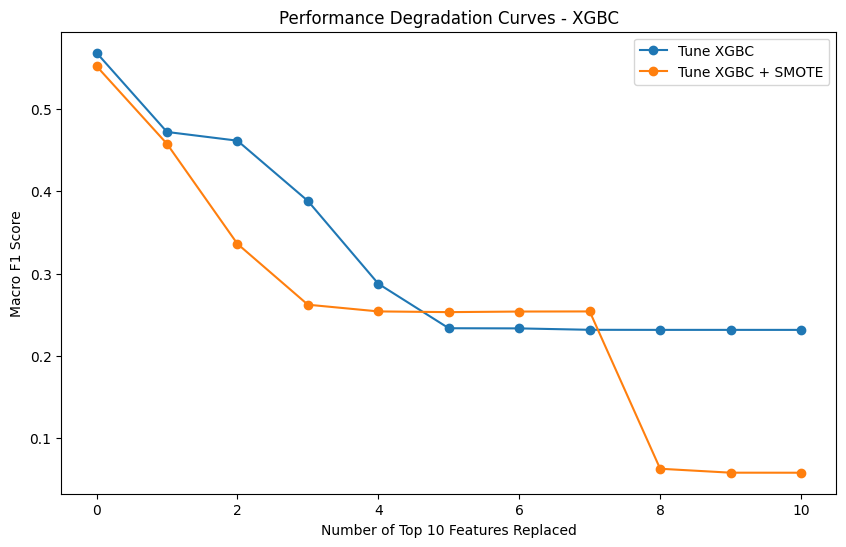

In [63]:
# Plot the performance degradation curve
fig = plt.figure(figsize=(10, 6))

# Plot each performance degradation curve and graph_perf_deg_xgbc_df add col_name to the legend
for column in graph_perf_deg_xgbc_df.columns:
    plt.plot(range(graph_perf_deg_xgbc_df.shape[0]), graph_perf_deg_xgbc_df[column], marker='o', label=column)

plt.title('Performance Degradation Curves - XGBC')
plt.xlabel('Number of Top 10 Features Replaced')
plt.ylabel('Macro F1 Score')
plt.grid(False)
plt.legend()
plt.show()

In [64]:
fig.savefig('performance_degra_tune_xgbc.pdf')

In [1]:
import numpy as np
import pandas as pd

# Manually creating dataframe to prevent from re-running predictions
graph_perf_deg_xgbc = {
    'Tune XGBC': [0.568554, 0.472235, 0.461626, 0.388382, 0.287684, 0.233607, 0.233410, 0.231698, 0.231607, 0.231610, 0.231592],
    'Tune XGBC + SMOTE': [0.552291, 0.457834, 0.336211, 0.262219, 0.254057, 0.253183, 0.253892, 0.254032, 0.062780, 0.057998, 0.057949]
}

graph_perf_deg_xgbc_df = pd.DataFrame(graph_perf_deg_xgbc)

# Calculate the Performance degradation AUC using the trapezoidal rulee
auc_tune_xgbc = np.trapz(graph_perf_deg_xgbc_df['Tune XGBC'])
auc_tune_xgbc_smote = np.trapz(graph_perf_deg_xgbc_df['Tune XGBC + SMOTE'])

print(f"Performance degradation AUC for Tune XGBC: {auc_tune_xgbc}")
print(f"Performance degradation AUC for Tune XGBC + SMOTE: {auc_tune_xgbc_smote}")


AUC for Tune XGBC: 3.171932
AUC for Tune XGBC + SMOTE: 2.497326
